In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('/Users/thanoskaraiskos/Documents/GitHub/city-bike/data/Trips_2018/Trips_2018_clean.csv', parse_dates=['start_time', 'stop_time'])
df.head()
# df.info()

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_time,stop_time
0,970,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1992,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186
1,723,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1969,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341
2,496,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1956,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172
3,306,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1974,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191
4,306,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1992,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642


In [3]:
# Get US holidays for the year 2018
us_holidays = holidays.US(years=[2018])

# Extract date type from start_time
df['date'] = df['start_time'].dt.date

# Define the category of the date
def categorize_date(date):
    if pd.to_datetime(date).weekday() >= 5:  # 5 = Saturday, 6 = Sunday
        return 'Weekend'
    elif date in us_holidays:
        return 'Holiday'
    else:
        return 'Weekday'
    
# Apply the categorization
df['category'] = df['date'].apply(categorize_date)

In [4]:
# Calculate the total trips per individual category
daily_counts = df.groupby(['date', 'category']).size().reset_index(name='daily_trips')

# Calculate the average daily trips for each category
result = daily_counts.groupby('category')['daily_trips'].mean().round(2)

print(result)
print(daily_counts.head())

category
Holiday    32949.90
Weekday    51719.76
Weekend    40717.32
Name: daily_trips, dtype: float64
         date category  daily_trips
0  2018-01-01  Holiday         5500
1  2018-01-02  Weekday        18818
2  2018-01-03  Weekday        24299
3  2018-01-04  Weekday         1922
4  2018-01-05  Weekday         4972


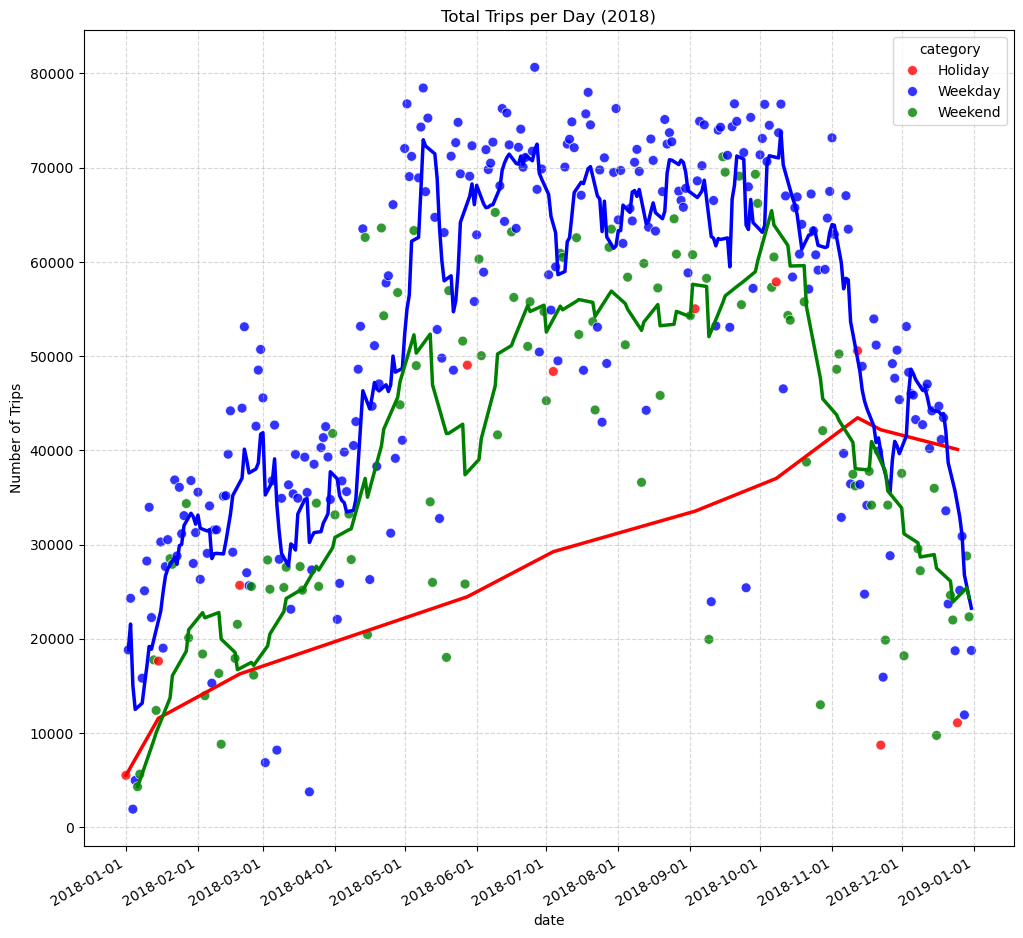

In [15]:
# Prepare the data (Count trips per day)
daily_counts = df.groupby(['date', 'category']).size().reset_index(name='trip_count')

plt.figure(figsize=(12,12))

sns.scatterplot(data=daily_counts, x='date', y='trip_count', hue='category', 
                palette={'Weekday': 'blue', 'Weekend': 'green', 'Holiday': 'red'},
                s=50, alpha=0.8)

# Moving Average for better trend visualization
daily_counts['trip_count_MA7'] = daily_counts.groupby('category')['trip_count'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
sns.lineplot(data=daily_counts, x='date', y='trip_count_MA7', hue='category', 
             palette={'Weekday': 'blue', 'Weekend': 'green', 'Holiday': 'red'},
             linewidth=2.5, legend=False)

# Format the Date Axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()

plt.title('Total Trips per Day (2018)')
plt.ylabel('Number of Trips')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [6]:
order = ['Weekday', 'Weekend', 'Holiday']

# Average trip duration per category
average_duration = df.groupby('category')['tripduration'].mean()

# Print the results
print("\nAverage Trip Duration by Category (in seconds):")
for category in order:
    if category in average_duration:
        print(f"{category}: {average_duration[category]:.2f} seconds")


Average Trip Duration by Category (in seconds):
Weekday: 926.50 seconds
Weekend: 1170.30 seconds
Holiday: 1091.28 seconds


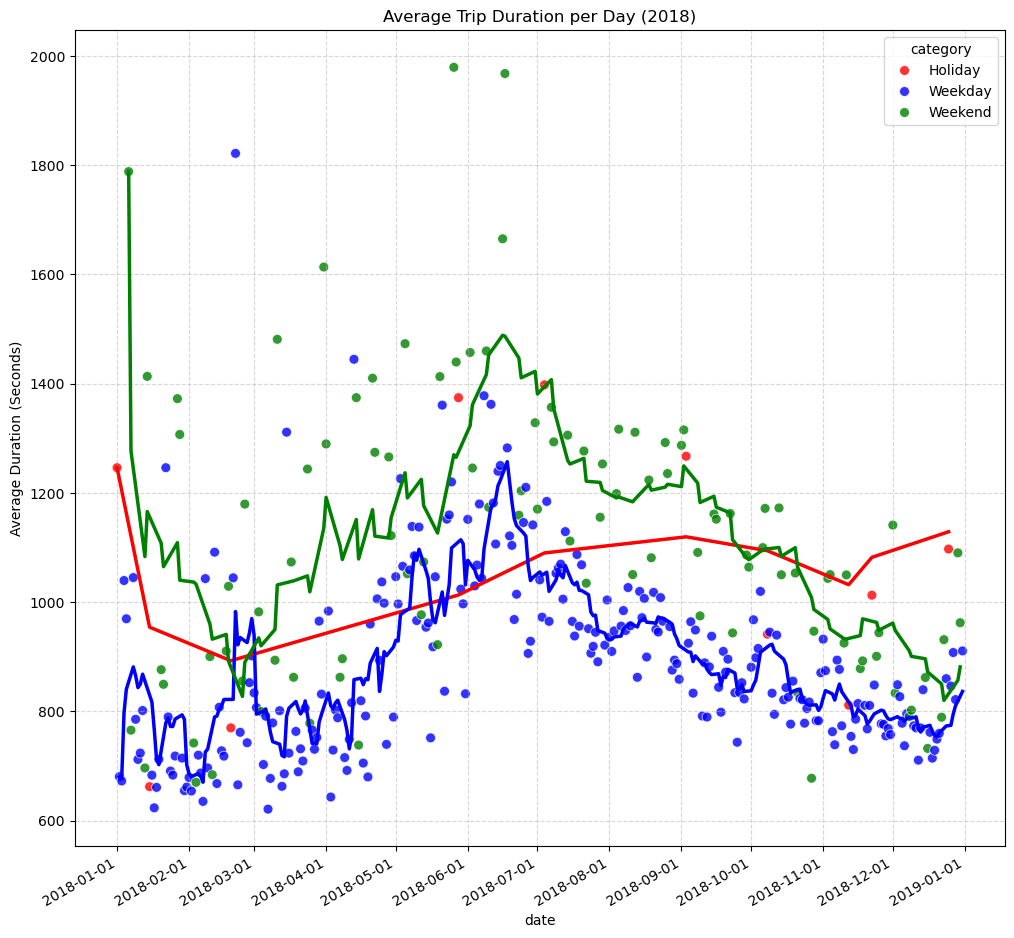

In [16]:
# 3. Calculate Total Trip Duration per Day
# We group by date and category, then SUM the 'tripduration' column
daily_duration = df.groupby(['date', 'category'])['tripduration'].mean().reset_index(name='total_duration')

# Optional: Convert seconds to Hours for better readability
# daily_duration['total_duration'] = daily_duration['total_duration'] / 3600

# 4. Plotting
plt.figure(figsize=(12,12))

# Moving Average for better trend visualization
daily_duration['total_duration_MA7'] = daily_duration.groupby('category')['total_duration'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
sns.lineplot(data=daily_duration, x='date', y='total_duration_MA7', hue='category', 
             palette={'Weekday': 'blue', 'Weekend': 'green', 'Holiday': 'red'},
             linewidth=2.5, legend=False)

sns.scatterplot(data=daily_duration, x='date', y='total_duration', 
                hue='category', 
                palette={'Weekday': 'blue', 'Weekend': 'green', 'Holiday': 'red'},
                s=50, alpha=0.8)

# Format the Date Axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()

# Update Titles and Labels
plt.title('Average Trip Duration per Day (2018)')
plt.ylabel('Average Duration (Seconds)')  # Update this label if you converted to hours
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

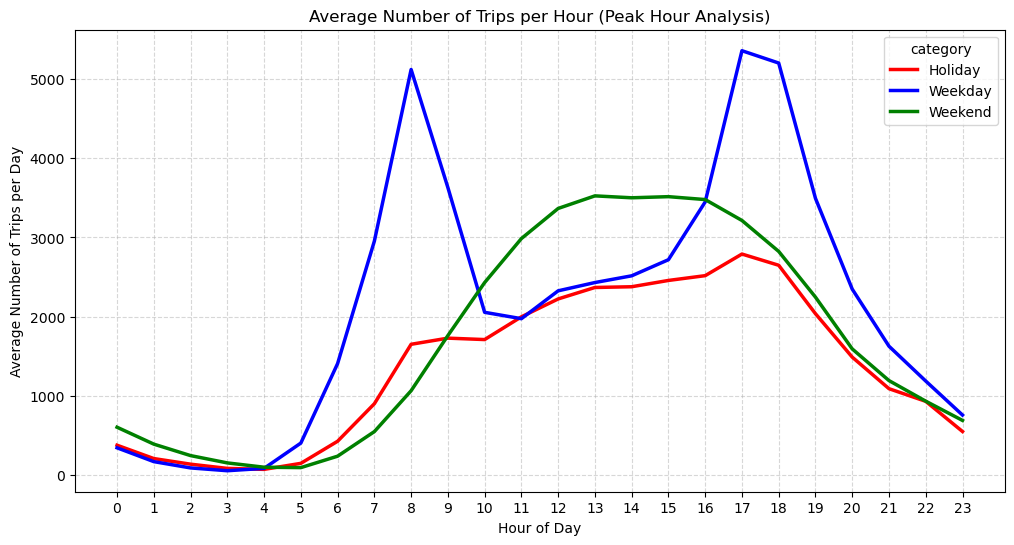

In [ ]:
# 1. Calculate the total trips per hour for each category
hourly_counts = df.groupby(['category', 'hour']).size().reset_index(name='total_trips')

# 2. Calculate the number of unique days for each category
# (We need this to normalize. E.g., if you have data for 100 weekdays, divide by 100)
days_per_category = df.groupby('category')['start_time'].apply(lambda x: x.dt.date.nunique())

# 3. Calculate "Average Trips" by dividing Total Trips by Number of Days
hourly_counts['avg_trips'] = hourly_counts.apply(
    lambda row: row['total_trips'] / days_per_category[row['category']], axis=1
)

# 4. Plot the results
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=hourly_counts, 
    x='hour', 
    y='avg_trips', 
    hue='category', 
    palette={'Weekday': 'blue', 'Weekend': 'green', 'Holiday': 'red'},
    linewidth=2.5
)

plt.title('Average Number of Trips per Hour (Peak Hour Analysis)')
plt.ylabel('Average Number of Trips per Day')
plt.xlabel('Hour of Day')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(0, 24)) # Show all hours
plt.show()

In [8]:
# Calculate average age for each category

df['age'] = 2018 - df['birth_year']
average_age = df.groupby('category')['age'].mean()
median_age = df.groupby('category')['age'].median()

print("\nAverage Age by Category:")
for category in order:
    if category in average_age:
        print(f"{category}: {average_age[category]:.2f} years")
print("\n")
print("Median Age by Category:")
for category in order:
    if category in average_age:
        print(f"{category}: {median_age[category]:.2f} years")



Average Age by Category:
Weekday: 39.15 years
Weekend: 38.60 years
Holiday: 38.86 years


Median Age by Category:
Weekday: 37.00 years
Weekend: 36.00 years
Holiday: 36.00 years


In [22]:
# Calculate gender as percentage of total for each category

gender_counts = df.groupby(['category', 'gender']).size().unstack(fill_value=0)
gender_percentages = gender_counts.div(gender_counts.sum(axis=1), axis=0) * 100
print("Gender Counts by Category:")
print(gender_percentages)


Gender Counts by Category:
gender            0          1          2
category                                 
Holiday   12.266502  64.189269  23.544229
Weekday    6.514220  70.655150  22.830630
Weekend   14.126667  61.064171  24.809161


In [24]:
user_counts = df.groupby(['category', 'usertype']).size().unstack(fill_value=0)
user_percentages = user_counts.div(user_counts.sum(axis=1), axis=0) * 100
print("\nUser Type Counts by Category:")
print(user_percentages)


User Type Counts by Category:
usertype          0          1
category                      
Holiday   17.345728  82.654272
Weekday    7.855097  92.144903
Weekend   20.204666  79.795334


172.89722300911245
65.63487255271536
42.87976642579403
16.802591026154175
6.319474258148176
7.398753680515313
8.333622044698473


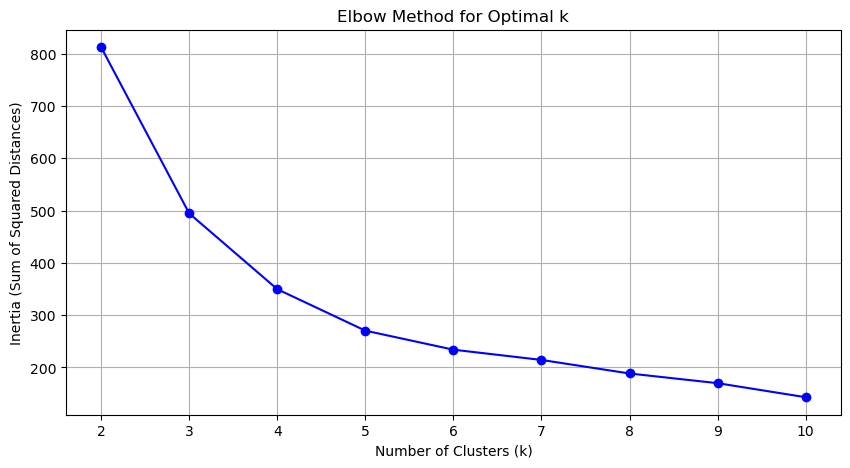

136.21820915178643
89.16783893187983
41.576856207184505
8.31367668253759
13.547259799738185
25.156681675852923
3.4234686549859816


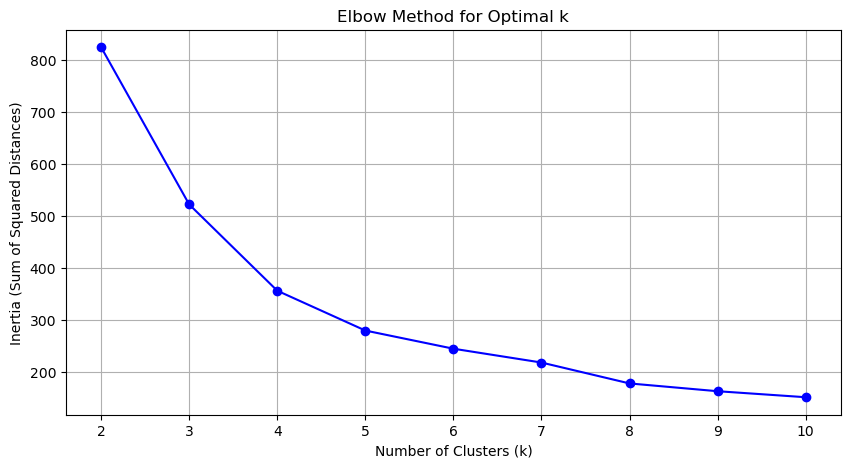

In [11]:
def average_daily_demand(df, station_col_name):
    daily_counts = df.groupby([station_col_name, 'date', 'category']).size().reset_index(name='trips')
    avg_demand = daily_counts.groupby([station_col_name, 'category'])['trips'].mean().unstack(fill_value=0)
            
    return avg_demand

departures = average_daily_demand(df, 'start_station_id')
arrivals = average_daily_demand(df, 'end_station_id')

scaler = StandardScaler()
departures_scaled = scaler.fit_transform(departures[['Weekday', 'Weekend', 'Holiday']])
arrivals_scaled = scaler.fit_transform(arrivals[['Weekday', 'Weekend', 'Holiday']])

def elbow_method(data_scaled):
    inertia = []
    k_range = range(2, 11)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data_scaled)
        inertia.append(kmeans.inertia_)
    
    for i in range(1, len(k_range) - 1):
        k = k_range[i]
        
        slope_before = inertia[i] - inertia[i-1]
        slope_after = inertia[i+1] - inertia[i]
        slope_diff = abs(slope_before - slope_after)
        print(slope_diff)
        
    plt.figure(figsize=(10, 5))
    plt.plot(k_range, inertia, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Sum of Squared Distances)')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()

elbow_method(departures_scaled)
elbow_method(arrivals_scaled)

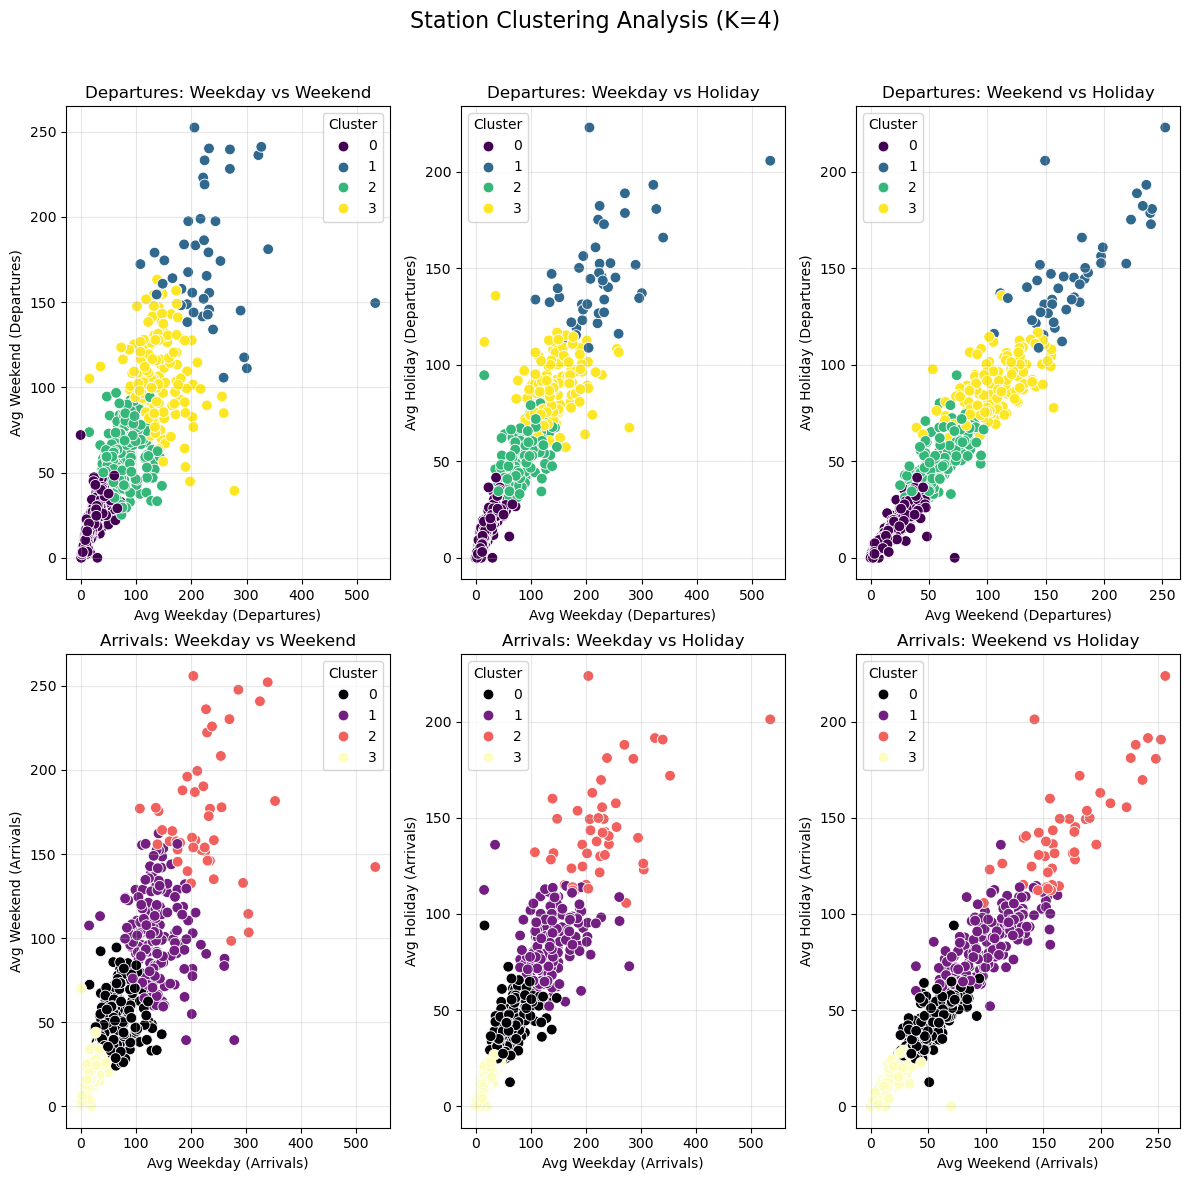

In [25]:
k = 4

departure_kmeans = KMeans(n_clusters=k, random_state=42)
departures['Cluster'] = departure_kmeans.fit_predict(departures_scaled)

arrival_kmeans = KMeans(n_clusters=k, random_state=42)
arrivals['Cluster'] = arrival_kmeans.fit_predict(arrivals_scaled)

fig, axes = plt.subplots(2, 3, figsize=(12, 12))
fig.suptitle(f'Station Clustering Analysis (K={k})', fontsize=16)

pairs = [('Weekday', 'Weekend'), ('Weekday', 'Holiday'), ('Weekend', 'Holiday')]

for i, (x_col, y_col) in enumerate(pairs):
    
    # --- Row 1: Departures ---
    sns.scatterplot(
        data=departures, x=x_col, y=y_col, hue='Cluster', 
        palette='viridis', ax=axes[0, i], s=60, legend='full'
    )
    axes[0, i].set_title(f'Departures: {x_col} vs {y_col}')
    axes[0, i].set_xlabel(f'Avg {x_col} (Departures)')
    axes[0, i].set_ylabel(f'Avg {y_col} (Departures)')
    axes[0, i].grid(True, alpha=0.3)

    # --- Row 2: Arrivals ---
    sns.scatterplot(
        data=arrivals, x=x_col, y=y_col, hue='Cluster', 
        palette='magma', ax=axes[1, i], s=60, legend='full'
    )
    axes[1, i].set_title(f'Arrivals: {x_col} vs {y_col}')
    axes[1, i].set_xlabel(f'Avg {x_col} (Arrivals)')
    axes[1, i].set_ylabel(f'Avg {y_col} (Arrivals)')
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()